# <font color=#025dfa> Çoklu Mantar Sınıflandırması Estonya'da 10 Yaygın Mantar Türünün Belirlenmesi - Mushroom Multiclass Classification Identifying 10 Common Mushroom Species in Estonia

TR = Her yorum satırı kendisini üstündeki koda aittir. İlk olarak Türkçe, son olarak İngilizce yazıldı.

EN = Each comment line belongs to the code above it. It was first written in Turkish and lastly in English.

TR = Bu proje, Estonya'da yaygın olarak bulunan 10 farklı mantar türünü çoklu sınıflandırma teknikleri kullanarak sınıflandırmayı amaçlamaktadır. Şapka şekli, renk, solungaç yapısı ve yaşam alanı gibi özellikleri analiz ederek, model bu mantar türleri arasında ayrım yapmak üzere eğitilecektir. Mantarların doğru sınıflandırılması, bazı türler yenilebilirken diğerleri zehirli olduğundan, çevre çalışmaları, biyolojik çeşitlilik izleme ve hatta halk sağlığı için çok önemlidir. Derin öğrenme ve görüntü tanıma tekniklerinden yararlanan bu proje, mantarları yüksek doğrulukla tanımlayabilen ve hem ekolojik araştırmaya hem de yiyecek arama güvenliğine katkıda bulunan bir model geliştirecektir.

EN = This project aims to classify 10 different species of mushrooms commonly found in Estonia using multiclass classification techniques. By analyzing features such as cap shape, color, gill structure, and habitat, the model will be trained to differentiate between these mushroom types. Accurate classification of mushrooms is crucial for environmental studies, biodiversity monitoring, and even public health, as some species are edible while others are poisonous. Leveraging deep learning and image recognition techniques, this project will develop a model capable of identifying mushrooms with high accuracy, contributing to both ecological research and safety in foraging.

Kaynak/Source = https://www.kaggle.com/competitions/mushroom-multiclass-classification/overview

In [1]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore') 


from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Conv2D, InputLayer , Reshape , MaxPooling2D, Flatten, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [3]:
df=pd.read_csv('train.csv')
image_directory = r'C:\Users\ErenK\OneDrive\Belgeler\Yapay Zeka\Proje\Computer Vision 1\mantar\dataset\dataset\\'

## <font color=#FFD700> EDA Keşif Amaçlı Veri Analizi - EDA - Exploratory Data Analysis 

In [4]:
df.head()

Image  Mushroom
0      1         0
1      2         0
2      3         0
3      4         0
4      5         0

In [5]:
df.sample(5)

Image  Mushroom
1319   1324         5
1955   1962         8
287     290         1
1589   1596         6
2002   2009         8

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Image     2365 non-null   int64
 1   Mushroom  2365 non-null   int64
dtypes: int64(2)
memory usage: 37.1 KB


In [7]:
df.shape

(2365, 2)

In [8]:
df['Image'] = df['Image'].apply(lambda x: f'{str(x).zfill(5)}.jpg')

In [9]:
df['Mushroom']=df['Mushroom'].map({0:'amanita',1:'boletus',2:'chantelle',3:'deterrimus',4:'rufus',5:'torminosus',6:'aurantiacum',7:'procera',8:'involutus',9:'russula'})

In [10]:
df.sample(5)

Image    Mushroom
549   00552.jpg   chantelle
809   00813.jpg  deterrimus
342   00345.jpg     boletus
1232  01237.jpg  torminosus
1369  01374.jpg  torminosus

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image     2365 non-null   object
 1   Mushroom  2365 non-null   object
dtypes: object(2)
memory usage: 37.1+ KB


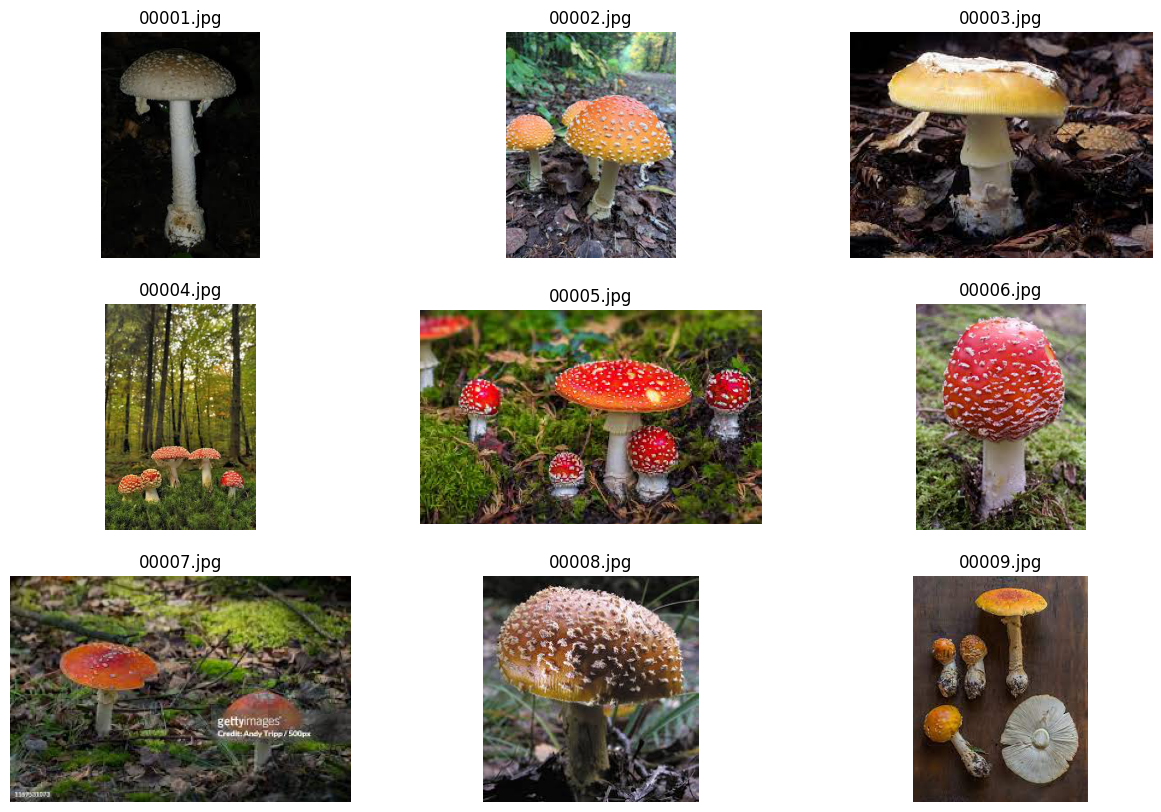

In [12]:
image_ids = df['Image']  
# TR = Veri çerçevesinden resim kimliklerini alır  
# EN = Retrieves image IDs from the DataFrame

plt.figure(figsize=(15, 10))  
# TR = Şekil boyutunu ayarlar  
# EN = Sets the figure size

for i, image_id in enumerate(image_ids[:9]):  
    # TR = İlk 9 resim için döngü başlatır  
    # EN = Starts a loop for the first 9 images
    
    img = mpimg.imread(image_directory + image_id)
    # TR = Resmi dosyasından okur  
    # EN = Reads the image from the file
    
    plt.subplot(3, 3, i + 1)
    # TR = 3 satır ve 3 sütunlu bir düzen oluşturur  
    # EN = Creates a 3-row and 3-column layout
    
    plt.imshow(img)
    # TR = Resmi gösterir  
    # EN = Displays the image
    
    plt.axis('off')
    # TR = Eksenleri gizler  
    # EN = Hides the axes
    
    plt.title(image_id)
    # TR = Resim başlığını belirler  
    # EN = Sets the title for the image

In [13]:
x = []  
# TR = Resimleri depolamak için boş bir liste oluşturur  
# EN = Creates an empty list to store images

size = 64  # TR = Resimlerin boyutunu belirler  
# EN = Sets the size for the images

for img_name in df['Image']:  
    # TR = Veri çerçevesindeki her resim adı için döngü başlatır  
    # EN = Starts a loop for each image name in the DataFrame
    
    img = cv2.imread(image_directory + str(img_name)) 
    # TR = Resmi dosyasından okur  
    # EN = Reads the image from the file
    
    if img is not None:  
        # TR = Eğer resim başarıyla yüklendiyse  
        # EN = If the image was loaded successfully
        
        img = cv2.resize(img, (size, size))
        # TR = Resmi belirtilen boyuta yeniden boyutlandırır  
        # EN = Resizes the image to the specified size
        
        img = img / 255.0
        # TR = Pixel values are normalized between 0 and 1  
        # EN = Normalizes the pixel values to be between 0 and 1

        x.append(img)  
        # TR = Processed image is added to the list  
        # EN = Adds the processed image to the list
    else:  
        print(f"Görüntü yüklenirken hata oluştu: {img_name}")  
        # TR = Hata mesajı yazdırır  
        # EN = Prints an error message if the image fails to load


In [14]:
x=np.array(x)
# TR = Yazıyı resim olarak okuyor bu yüzden diziye çevirdik.
# EN = The text is read as an image, so we converted it to an array

In [15]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Mushroom'])

## <font color='#0F52BA'> Öznitelik Mühendisliği - Feature Engineering

### <font color=#007fff> Model - Modelling 

In [16]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=42)
# TR = modelimizi eğittik. 
# EN = We trained our model.

In [17]:
model = Sequential()
# TR = Ardışık bir model oluşturur, katmanlar sıralı olarak eklenir.
# EN = Creates a sequential model where layers are added in a linear stack.

model.add(InputLayer(input_shape=(size,size,3)))
# TR = Modelin giriş katmanını tanımlar ve veri boyutunu belirtir, bu durumda her görüntü sizexsize pikseldir.
# EN = Defines the input layer of the model and specifies the data dimensions, in this case, each image is sizexsize pixels.

model.add(Reshape(target_shape=(size,size,3)))
# TR = Veriyi sizexsizex3 şeklinde yeniden düzenler.
# EN = Reshapes the data to sizexsizex3.

model.add(Conv2D(filters=12, kernel_size=(3,3), activation='relu'))
# TR = Konvolüsyon işlemi ile özellikleri çıkarır, filtreler görüntüdeki desenleri öğrenir ve 'relu' aktivasyon fonksiyonu ile doğrusal olmayan ilişkileri modellemesini sağlar.
# EN = Extracts features via convolution, where filters learn patterns in the image and the 'relu' activation function introduces non-linearity.

model.add(MaxPooling2D(pool_size=(2,2)))
# TR = Özellik haritasını küçültür ve en belirgin özellikleri seçer, böylece hesaplama maliyeti azalır ve modelin genelleştirme yeteneği artar.
# EN = Reduces the feature map size and selects the most prominent features, reducing computation and improving the model’s ability to generalize.

model.add(Flatten())
# TR = Çok boyutlu veri kümesini tek boyutlu bir vektöre dönüştürür, tam bağlantılı katmanlarla işlem için uygun hale getirir.
# EN = Converts the multi-dimensional feature map into a one-dimensional vector to be processed by fully connected layers.

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10,activation='softmax'))
# TR = Sonuçları 10 farklı sınıfa dönüştüren bir tam bağlantılı katman ekler, bu da modelin sınıflandırma yapmasını sağlar.
# EN = Adds a fully connected layer with 10 units to output results for 10 different classes, enabling classification.

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# TR = Modeli 'adam' optimizasyonu ile derler, bu optimizasyon algoritması öğrenmeyi iyileştirir, ve 'SparseCategoricalCrossentropy' kayıp fonksiyonunu kullanarak çok sınıflı sınıflandırma yapar, doğruluk metriğiyle model performansını değerlendirir.
# EN = Compiles the model with the 'adam' optimizer, which improves learning, uses 'SparseCategoricalCrossentropy' loss function for multi-class classification, and evaluates performance with accuracy metric.

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, validation_split=0.1, epochs=30, callbacks=[early_stop])
# TR = Modeli eğitim verileri (x_train) ve etiketleri (y_train) ile eğitir, %10'luk bir doğrulama seti kullanır ve 20 dönem boyunca eğitir.
# EN = Trains the model with the training data (x_train) and labels (y_train), uses 10% of the data for validation, and trains for 20 epochs.

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.1256 - loss: 2.4282 - val_accuracy: 0.1895 - val_loss: 2.2474
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1417 - loss: 2.2711 - val_accuracy: 0.1684 - val_loss: 2.2208
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2095 - loss: 2.1680 - val_accuracy: 0.1684 - val_loss: 2.1800
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2643 - loss: 2.0685 - val_accuracy: 0.2842 - val_loss: 2.0708
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3449 - loss: 1.8298 - val_accuracy: 0.3211 - val_loss: 1.9826
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4156 - loss: 1.7071 - val_accuracy: 0.3421 - val_loss: 1.9202
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4939 - loss: 1.4963 - val_accuracy: 0.3895 - val_loss: 1.8987
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5323 - loss: 1.3523 - val_accuracy: 0.4211 - v

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 12)          │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 11532)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,476,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,433,552 (16.91 MB)

 Trainable params: 1,477,850 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,955,702 (11.28 MB)

In [19]:
loss, _accuracy = model.evaluate(x_test, y_test)
# TR = Test verileri (test_images) ve etiketleri (test_labels) ile modelin performansını değerlendirir, kayıp ve doğruluk değerlerini döndürür.
# EN = Evaluates the model's performance using test data (test_images) and labels (test_labels), returning loss and accuracy values.

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3521 - loss: 1.8245


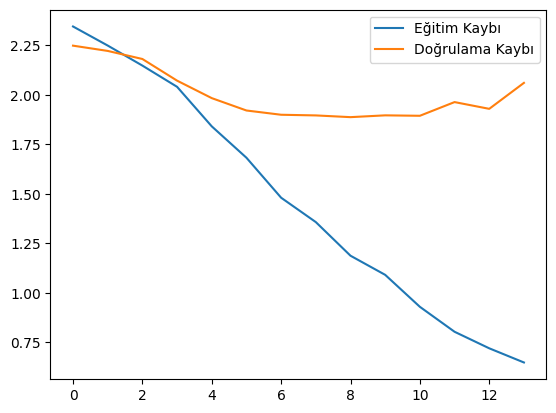

In [20]:
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend()
plt.show()

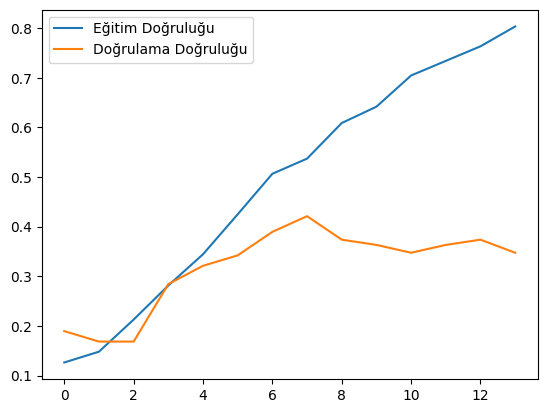

In [21]:
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.legend()
plt.show()

In [23]:
model.save('Mantar_CNN_model.keras')